***
# Approximation and inference of non-Markov models of gene expression by neural network chemical master equations
***

In [ ]:
using Flux, DiffEqSensitivity, DifferentialEquations
using Distributions, Distances
using DelimitedFiles, Plots

In [3]:
using Random
Random.seed!(1234);

## Data preprocessing

In [9]:
# load train data
source_data = readdlm("$(homedir())/Desktop/NN-CME/SSA_sinlge_channel_tau10.csv",',');

# truncation
N = Int(maximum(source_data));

# randomly select samples
trajectory = 1000;
train_data = source_data[:, rand(2:50001, trajectory)];
(nrows, ncols) = size(train_data);

# calculate the probabilities at 0~N
train_sol = zeros(N+1, 51);
for i in 0:N
        for j in 1:51
                count = 0;
                for k in 1:trajectory
                         if train_data[j,k] == i
                                  count = count + 1/trajectory;
                         end
                end
                train_sol[i+1, j] = count;
        end
end

## Train neural network chemical master equation (NN-CME) for Model I

In [10]:
# model initialization
model = Chain(Dense(N+1, 100, tanh), Dense(100, N), x -> x .+ [i/10 for i in 1:N], x -> relu.(x));
p1, re = Flux.destructure(model);
ps = Flux.params(p1);

# define the CME
function CME(du, u, p, t)
     ρ = 20.0;  
     NN = re(p)(u);
    
     du[1] = -ρ*u[1] + NN[1]*u[2];
     for i in 2:N
           du[i] = ρ*u[i-1] + (-ρ - NN[i-1])*u[i] + NN[i]*u[i+1];
     end
     du[N+1] = ρ*u[N] + (-ρ - NN[N])*u[N+1];
end

# initialize the ODE solver
u0 = [1.; zeros(N)]; 
tspan = (0.0, 50.0);
problem = ODEProblem(CME, u0, tspan, p1);

# define the objective function
function loss_adjoint()
      # solve ODE problem and save at the selected time
      sol = Array(solve(problem, Tsit5(), u0=u0, p=p1, saveat=[4,8,14,20,26,32,38,44,50]));
      # calculate MSE at the selected time between train data and fitted data
      Flux.mse(sol, train_sol[:, [3,5,8,11,14,17,20,23,26]])

end

# start training with piece-wise learning rate
@time Flux.train!(loss_adjoint, ps, Iterators.repeated((), 7), ADAM(0.25))
@time Flux.train!(loss_adjoint, ps, Iterators.repeated((), 8), ADAM(0.12))
@time Flux.train!(loss_adjoint, ps, Iterators.repeated((), 2), ADAM(0.02))

128.007303 seconds (982.19 M allocations: 152.868 GiB, 6.34% gc time)
141.436129 seconds (1.11 G allocations: 174.257 GiB, 6.32% gc time)
 34.916876 seconds (277.44 M allocations: 43.530 GiB, 5.38% gc time)


## Evaluate after training

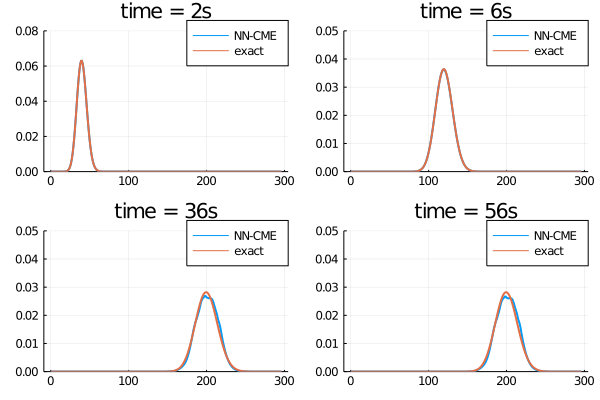

In [11]:
# calculate the NN-CME probabilities
u0 = [1.; zeros(N)]; 
use_time=100.0; 
time_step = 2.0; 
tspan = (0.0, use_time);
problem = ODEProblem(CME, u0, tspan, p1);

sol = Array(solve(problem, Tsit5(), u0=u0, p=ps[1], saveat=0:time_step:Int(use_time)));

# plot the selected snapshots
bins = collect(0:N);
f11 = plot(bins, [sol[:, 2] pdf.(Poisson(20*2), bins)], ylim=(0, 0.08), linewidth=[2 2], label=["NN-CME" "exact"], title="time = 2s");
f12 = plot(bins, [sol[:, 4] pdf.(Poisson(20*6), bins)], ylim=(0, 0.05), linewidth=[2 2], label=["NN-CME" "exact"], title="time = 6s");
f21 = plot(bins, [sol[:, 19] pdf.(Poisson(20*10), bins)], ylim=(0, 0.05), linewidth=[2 2], label=["NN-CME" "exact"], title="time = 36s");
f22 = plot(bins, [sol[:, 29] pdf.(Poisson(20*10), bins)], ylim=(0, 0.05), linewidth=[2 2], label=["NN-CME" "exact"], title="time = 56s");
plot(f11, f12, f21, f22, layout=(2,2))
